# Energy Data Analysis

This notebook builds the **data backbone** for a mobile-first platform that helps Moldovan consumers and providers **see, understand, and shift** electricity use. It turns raw smart-meter exports into **clean, calibrated, and explainable** time series ready for analytics, forecasting, nudges, and tariff simulation.

This notebook compiles messy smart-meter CSVs and turns cumulative counters into reliable 15-minute consumption. It auto-handles bad files, detects resets/rollovers, removes spikes (MAD), fills short gaps (≤1 h), and applies a learned physical cap per meter. It then calibrates each meter so 15-minute sums match daily counter deltas, flags day-level data quality (complete vs. suspect), aggregates to hourly/daily, and outputs clean datasets plus quick validations and plots.

### Why it matters:

Trustworthy data is the foundation for everything we will build: clear hourly curves, fair “shift your use” nudges, accurate tariff “worth it / not worth it” estimates, and stable provider dashboards. By making the series clean, calibrated, and explainable—and by flagging low-quality days, we prevent bad data from driving decisions, improve user trust, and enable credible peak detection, forecasting, and demand-response simulations.

In [1]:
import os, glob, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## CSV loading

In [2]:
%matplotlib inline

In [3]:
PLOTS_DIR = Path("plots"); PLOTS_DIR.mkdir(exist_ok=True)

def save_or_show(name: str, show_inline=True):
    out = PLOTS_DIR / f"{name}.png"
    plt.savefig(out, dpi=150, bbox_inches="tight")
    print(f"[PLOT] Saved: {out}")
    if ("ipykernel" in sys.modules) and show_inline:
        plt.show()
    plt.close()

In [4]:
try: # works for both .py file and jupyter notebook
    HERE = Path(__file__).parent.resolve() 
except NameError:
    HERE = Path.cwd().resolve()             

DATA_DIR = (HERE / "data").resolve()         
print(f"[PATH] Using data dir: {DATA_DIR}")

# Optional override:
if os.getenv("DATA_DIR"):
    DATA_DIR = Path(os.getenv("DATA_DIR")).expanduser().resolve()
    print(f"[PATH] Overridden by DATA_DIR env: {DATA_DIR}")

assert DATA_DIR.is_dir(), f"Data directory not found: {DATA_DIR}"

[PATH] Using data dir: C:\Users\user\PycharmProjects\chimie\cod\data


In [5]:
REQ_COLS = {
   "Meter": "meter_id",
   "Clock (8:0-0:1.0.0*255:2)": "timestamp",
   "Active Energy Import (3:1-0:1.8.0*255:2)": "import_kwh_cum",
   "Active Energy Export (3:1-0:2.8.0*255:2)": "export_kwh_cum",
   "TransFullCoef": "transform_coef",
}

In [6]:
def try_read_csv(path: str) -> pd.DataFrame | None:
   problems = []
   for sep in [";", ",", r"[;,]"]:
       try:
           df = pd.read_csv(
               path,
               sep=sep,
               encoding="utf-8-sig",
               engine="python",
               on_bad_lines="skip",
           )
       except Exception as e:
           problems.append(f"read_error({sep}): {e}")
           continue


       if df is None or df.empty:
           problems.append(f"empty_or_none({sep})")
           continue


       df.columns = [c.strip() for c in df.columns]
       if len(df.columns) == 1 and df.columns[0] == "":
           problems.append(f"single_blank_column({sep})")
           continue


       # convert names to standard ones
       colmap = {}
       for src, dst in REQ_COLS.items():
           if src in df.columns:
               colmap[src] = dst


       if "Meter" not in colmap:
           maybe = [c for c in df.columns if c.lower().startswith("meter")]
           if maybe:
               colmap[maybe[0]] = "meter_id"


       if "Clock (8:0-0:1.0.0*255:2)" not in colmap:
           maybe = [c for c in df.columns if "1.0.0*255" in c or "clock" in c.lower()]
           if maybe:
               colmap[maybe[0]] = "timestamp"


       needed = {"meter_id", "timestamp", "import_kwh_cum"}
       if not needed.issubset(set(colmap.values())):
           problems.append(f"missing_headers({sep}): {df.columns[:6].tolist()}")
           continue


       df = df.rename(columns=colmap)
       keep = [c for c in ["meter_id", "timestamp", "import_kwh_cum", "export_kwh_cum", "transform_coef"] if c in df.columns]
       df = df[keep].copy()


       df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d.%m.%Y %H:%M:%S", errors="coerce")
       for c in ["import_kwh_cum", "export_kwh_cum", "transform_coef"]:
           if c in df.columns:
               df[c] = pd.to_numeric(df[c], errors="coerce")


       df.dropna(subset=["timestamp", "meter_id", "import_kwh_cum"], inplace=True)
       if df.empty:
           problems.append(f"no_valid_rows_after_parse({sep})")
           continue


       # normalize meter_id to str early
       df["meter_id"] = df["meter_id"].astype(str)


       return df  # success

   print(f"[SKIP] {os.path.basename(path)} -> {' | '.join(problems)}")
   return None

In [7]:
def load_all(data_dir: str, pattern: str = "*.csv") -> pd.DataFrame:
   files = sorted(glob.glob(os.path.join(data_dir, pattern)))
   print(f"[INFO] Found {len(files)} files in {data_dir}")
   dfs, skipped = [], []
   for f in files:
       df = try_read_csv(f)
       if df is not None and not df.empty:
           dfs.append(df)
       else:
           skipped.append(os.path.basename(f))
   if skipped:
       print(f"[WARN] Skipped {len(skipped)} files; first few: {skipped[:5]}")
   if not dfs:
       raise RuntimeError("No readable CSVs found.")
   out = pd.concat(dfs, ignore_index=True)
   if "transform_coef" not in out.columns:
       out["transform_coef"] = 1.0
   # meter_id as string
   out["meter_id"] = out["meter_id"].astype(str)
   out = out.sort_values(["meter_id", "timestamp"]).reset_index(drop=True)
   return out

## Cleaning helpers

In the code, we take the per-interval diffs of a cumulative counter (kWh). True consumption should be non-negative and within a reasonable range. Sometimes a meter rolls over (counter resets or overflows) or glitches, producing a nonsense jump—a big negative value or an absurdly large positive one.  
Example: if typical 15-min diffs are ≤1 kWh, the bound is ~10 kWh. Anything above that is almost certainly a glitch and gets excluded from further calculations.

In [8]:
def mark_bad_diffs_series(s: pd.Series) -> pd.Series:
   s = s.copy()
   neg = s < 0
   pos = s[s > 0]
   if len(pos) > 0:
       upper = pos.quantile(0.99) * 10  # soft bound for rollovers
       big = s > upper
   else:
       big = s > np.inf
   s[neg | big] = np.nan
   return s

In [9]:
def mad_clip_series(s: pd.Series, k: float = 6.0) -> pd.Series:
   x = s.dropna()
   if len(x) < 10:
       return s
   med = x.median()
   mad = (np.abs(x - med)).median()
   if mad == 0:
       return s
   rz = (s - med) / (1.4826 * mad)
   return s.where(rz.abs() <= k)

In [10]:
def phys_cap_series_15min_kwh(s: pd.Series) -> pd.Series:
   # 15-min kWh - kW (×4), cap at per-meter 99.9th pct × 1.2, then back to kWh
   kW = s * 4.0
   finite = kW[np.isfinite(kW) & (kW >= 0)]
   if len(finite) == 0:
       return s
   cap = finite.quantile(0.999) * 1.2
   capped_kW = np.minimum(kW, cap)
   return capped_kW / 4.0

The following code converts raw cumulative meter counters into a clean 15-min consumption series per meter. Steps: difference the import/export counters, drop impossible jumps (negatives/rollovers), scale by `transform_coef`, and null any remaining negatives. Then clean in three passes—MAD outlier clip, short gap fill (≤1 hour), and a learned physical cap (per-meter 99.9th-pct load). The result is `consumption_15min_kwh_clean` (and `export_15min_kwh_clean` if present), ready for aggregation, forecasts, and tariff sims.

In [11]:
def compute_clean(raw_in: pd.DataFrame, k_mad: float = 6.0) -> pd.DataFrame:
   df = raw_in.copy()
   df["meter_id"] = df["meter_id"].astype(str) 


   df["import_diff"] = df.groupby("meter_id")["import_kwh_cum"].diff()
   if "export_kwh_cum" in df.columns:
       df["export_diff"] = df.groupby("meter_id")["export_kwh_cum"].diff()
   else:
       df["export_diff"] = np.nan


   gb = df.groupby("meter_id", group_keys=False)


   df["import_diff"] = gb["import_diff"].apply(mark_bad_diffs_series).astype(float)
   df["export_diff"] = gb["export_diff"].apply(mark_bad_diffs_series).astype(float)


   coef = df["transform_coef"].fillna(1.0)
   df["consumption_15min_kwh"] = df["import_diff"] * coef
   df["export_15min_kwh"] = df["export_diff"] * coef
   for c in ["consumption_15min_kwh", "export_15min_kwh"]:
       df.loc[df[c] < 0, c] = np.nan


   df["consumption_15min_kwh_mad"] = gb["consumption_15min_kwh"].apply(lambda s: mad_clip_series(s, k=k_mad))


   df["consumption_15min_kwh_ff"] = gb["consumption_15min_kwh_mad"].apply(lambda s: s.ffill(limit=4))


   df["consumption_15min_kwh_physcap"] = gb["consumption_15min_kwh_ff"].apply(phys_cap_series_15min_kwh)


   df["consumption_15min_kwh_clean"] = df["consumption_15min_kwh_physcap"].fillna(0.0)


   if "export_15min_kwh" in df.columns:
       df["export_15min_kwh_mad"] = gb["export_15min_kwh"].apply(lambda s: mad_clip_series(s, k=k_mad))
       df["export_15min_kwh_ff"] = gb["export_15min_kwh_mad"].apply(lambda s: s.ffill(limit=4))
       df["export_15min_kwh_physcap"] = gb["export_15min_kwh_ff"].apply(phys_cap_series_15min_kwh)
       df["export_15min_kwh_clean"] = df["export_15min_kwh_physcap"].fillna(0.0)
   else:
       df["export_15min_kwh_clean"] = 0.0


   return df

## Aggregation & system cap

In [12]:
def aggregate(df: pd.DataFrame, freq: str = "h") -> pd.DataFrame:
   d = df.set_index("timestamp").sort_index()
   agg = d[["consumption_15min_kwh_clean", "export_15min_kwh_clean"]].resample(freq).sum()
   agg = agg.rename(columns={
       "consumption_15min_kwh_clean": "consumption_kwh",
       "export_15min_kwh_clean": "export_kwh"
   })
   return agg.reset_index()

In [13]:
def system_level_cap(hourly_df: pd.DataFrame, window_hours: int = 24*7, mult: float = 10.0) -> pd.DataFrame:
   """Second pass outlier control: cap hourly system load vs rolling median × mult."""
   df = hourly_df.copy().sort_values("timestamp")
   med = df["consumption_kwh"].rolling(
       window=window_hours,
       min_periods=max(4, window_hours // 4),
       center=False
   ).median()
   cap = med * mult
   df["consumption_kwh_syscapped"] = np.where(
       np.isfinite(cap),
       np.minimum(df["consumption_kwh"].values, cap.values),
       df["consumption_kwh"].values
   )
   return df

## Cadence, calibration 

In [14]:
def infer_meter_cadence_minutes(clean: pd.DataFrame) -> pd.DataFrame:
   # median interval (in minutes) per meter, rounded to 5/10/15/30/60
   df = clean[["meter_id","timestamp"]].dropna().copy()
   df["dt"] = df.groupby("meter_id")["timestamp"].diff().dt.total_seconds() / 60.0
   cand = df.dropna(subset=["dt"]).groupby("meter_id")["dt"].median().rename("median_minutes").to_frame()
   steps = np.array([5, 10, 15, 30, 60])
   def snap(x):
       if not np.isfinite(x): return 15.0
       return steps[np.argmin(np.abs(steps - x))]
   cand["cadence_min"] = cand["median_minutes"].apply(snap)
   cand["expected_per_day"] = (24*60 / cand["cadence_min"]).round().astype(int)
   return cand[["cadence_min","expected_per_day"]]

In [15]:
def calibrate_and_flag_completeness(clean: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
   """
   - Learns per-meter cadence and expected intervals/day.
   - Flags completeness using intervals, hours covered, and coverage window.
   - Calibrates per meter:
       1) Use median ratio on complete & plausible days (0.5–2.0),
       2) else use median ratio on complete days (no plausibility bound),
       3) else use total-series ratio (all days),
       4) else fallback 1.0.
   - Marks days with big ratio deviation as suspect; excludes them from 'complete'.
   """
   clean = clean.copy()
   clean["meter_id"] = clean["meter_id"].astype(str)


   cadence = infer_meter_cadence_minutes(clean)


   tmp = clean[["meter_id","timestamp","import_kwh_cum","consumption_15min_kwh_clean"]].copy()
   tmp["day"] = tmp["timestamp"].dt.floor("D")


   # per-day aggregates
   agg = tmp.groupby(["meter_id","day"]).agg(
       intervals=("timestamp","size"),
       first_ts=("timestamp","min"),
       last_ts=("timestamp","max"),
       hours_covered=("timestamp", lambda s: s.dt.floor("h").nunique()),
       sum_15min_kwh=("consumption_15min_kwh_clean","sum"),
       min_cum=("import_kwh_cum","min"),
       max_cum=("import_kwh_cum","max"),
   ).reset_index()
   agg["delta_cum_kwh"] = agg["max_cum"] - agg["min_cum"]
   agg["coverage_hours"] = (agg["last_ts"] - agg["first_ts"]).dt.total_seconds()/3600.0


   # completeness thresholds
   agg = agg.merge(cadence, on="meter_id", how="left")
   agg["expected_per_day"] = agg["expected_per_day"].fillna(96).astype(int)  # default 15-min cadence
   base_complete = (
       (agg["intervals"] >= np.floor(0.95 * agg["expected_per_day"])) &
       (agg["hours_covered"] >= 23) &
       (agg["coverage_hours"] >= 23.0)
   )


   # day ratio (only if positive)
   with np.errstate(divide="ignore", invalid="ignore"):
       agg["ratio"] = np.where(
           (agg["delta_cum_kwh"] > 0) & (agg["sum_15min_kwh"] > 0),
           agg["delta_cum_kwh"] / agg["sum_15min_kwh"],
           np.nan,
       )


   agg["suspect"] = base_complete & (~agg["ratio"].between(0.9, 1.1, inclusive="both"))


   agg["complete"] = base_complete & (~agg["suspect"])


   calib_rows = []
   for m, g in agg.groupby("meter_id"):
       r_complete_plaus = g.loc[g["complete"] & g["ratio"].between(0.5, 2.0), "ratio"].dropna()
       if len(r_complete_plaus) >= 1:
           factor = r_complete_plaus.median()
       else:
           r_complete = g.loc[g["complete"], "ratio"].dropna()
           if len(r_complete) >= 1:
               factor = r_complete.median()
           else:
               tot_delta = g["delta_cum_kwh"].sum(skipna=True)
               tot_sum = g["sum_15min_kwh"].sum(skipna=True)
               factor = (tot_delta / tot_sum) if (tot_delta > 0 and tot_sum > 0) else 1.0


       factor = float(np.clip(factor, 0.05, 20.0))
       calib_rows.append({"meter_id": m, "calib_factor": factor})


   calib = pd.DataFrame(calib_rows, columns=["meter_id","calib_factor"]).astype({"meter_id":str})


   # apply calibration
   clean2 = clean.merge(calib, on="meter_id", how="left")
   clean2["calib_factor"] = clean2["calib_factor"].fillna(1.0)
   clean2["consumption_15min_kwh_clean"] = clean2["consumption_15min_kwh_clean"] * clean2["calib_factor"]


   daily_flags = agg[["meter_id","day","intervals","expected_per_day","hours_covered","coverage_hours","ratio","suspect","complete"]].copy()
   meter_calibration = calib.copy()


   suspect = daily_flags[(daily_flags["complete"] == False) & (daily_flags["suspect"] == True)]
   if not suspect.empty:
       suspect.to_csv("suspect_days.csv", index=False)


   return clean2, meter_calibration, daily_flags

## Validation and diagnostics

In [16]:
def validation_reports(df_clean: pd.DataFrame, hourly: pd.DataFrame, daily_flags: pd.DataFrame) -> None:
    print("\n[VALIDATION] Clip ratios per meter (MAD + phys-cap + ffill):")
    g = pd.DataFrame({
        "orig": df_clean["consumption_15min_kwh"],
        "mad": df_clean["consumption_15min_kwh_mad"],
        "ff": df_clean["consumption_15min_kwh_ff"],
        "phys": df_clean["consumption_15min_kwh_physcap"],
        "clean": df_clean["consumption_15min_kwh_clean"],
        "meter_id": df_clean["meter_id"],
    })

    g["mad_clipped"] = np.where(np.isfinite(g["orig"]) & ~np.isfinite(g["mad"]), 1, 0)
    eps = 1e-9
    g["phys_capped"] = np.where(
        np.isfinite(g["ff"]) & np.isfinite(g["phys"]) & ((g["ff"] - g["phys"]) > eps), 1, 0
    )

    rep = g.groupby("meter_id").agg(
        total_intervals=("orig", "size"),
        mad_clipped=("mad_clipped", "sum"),
        phys_capped=("phys_capped", "sum"),
    )
    rep["mad_clip_pct"] = (rep["mad_clipped"] / rep["total_intervals"] * 100).round(2)
    rep["phys_cap_pct"] = (rep["phys_capped"] / rep["total_intervals"] * 100).round(2)
    print(rep.head(20))
    rep.sort_values("mad_clip_pct", ascending=False).to_csv("clip_report_by_meter.csv")

    # Energy conservation after calibration (on complete days)
    print("\n[VALIDATION] Energy conservation on complete days (sum 15-min vs counter delta):")
    tmp = df_clean[["meter_id", "timestamp", "import_kwh_cum", "consumption_15min_kwh_clean"]].copy()
    tmp["day"] = tmp["timestamp"].dt.floor("D")
    daily_cum = tmp.groupby(["meter_id", "day"])["import_kwh_cum"].agg(["min", "max"]).reset_index()
    daily_cum["delta_cum_kwh"] = daily_cum["max"] - daily_cum["min"]
    daily_sum = tmp.groupby(["meter_id", "day"])["consumption_15min_kwh_clean"].sum().reset_index(name="sum_15min_kwh")
    chk = pd.merge(daily_cum, daily_sum, on=["meter_id", "day"], how="inner")
    chk = chk.merge(daily_flags[["meter_id","day","complete"]], on=["meter_id","day"], how="left")
    chk["ratio_sum_to_delta"] = np.where(
        (chk["delta_cum_kwh"] > 0) & (chk["complete"] == True),
        chk["sum_15min_kwh"] / chk["delta_cum_kwh"],
        np.nan
    )
    print(chk[chk["complete"] == True].sort_values(["meter_id","day"]).head(20))

    suspect = chk[(chk["complete"] == True) & (~chk["ratio_sum_to_delta"].between(0.9, 1.1))]
    if not suspect.empty:
        suspect.to_csv("suspect_days.csv", index=False)
        print("\n[VALIDATION] Suspect complete days saved to suspect_days.csv (ratio outside 0.9–1.1)")

    # Spot-check plots for a few meters (unique filenames)
    example_meters = df_clean["meter_id"].dropna().unique()[:3]
    for m in example_meters:
        sub = df_clean[df_clean["meter_id"] == m].copy()

        plt.figure(figsize=(12, 5))
        plt.plot(sub["timestamp"], sub["import_kwh_cum"])
        plt.title(f"Meter {m} — Raw cumulative import (kWh)")
        plt.xlabel("Time"); plt.ylabel("kWh")
        plt.xticks(rotation=45); plt.tight_layout()
        save_or_show(f"raw_cumulative_import_{m}")

        plt.figure(figsize=(12, 5))
        plt.plot(sub["timestamp"], sub["consumption_15min_kwh"], label="diff", alpha=0.85)
        plt.plot(sub["timestamp"], sub["consumption_15min_kwh_clean"], label="clean (calibrated)", alpha=0.85)
        plt.title(f"Meter {m} — 15-min consumption: raw diff vs cleaned (calibrated)")
        plt.xlabel("Time"); plt.ylabel("kWh/15min"); plt.legend()
        plt.xticks(rotation=45); plt.tight_layout()
        save_or_show(f"consumption_15min_vs_clean_{m}")


## Main

[INFO] Found 28 files in C:\Users\user\PycharmProjects\chimie\cod\data
[SKIP] 03.06.2025 06_00_All measuring points_ExportFile.csv -> read_error(;): No columns to parse from file | read_error(,): No columns to parse from file | read_error([;,]): No columns to parse from file
[SKIP] 03.06.2025 18_01_All measuring points_ExportFile.csv -> read_error(;): No columns to parse from file | read_error(,): No columns to parse from file | read_error([;,]): No columns to parse from file
[SKIP] 04.06.2025 06_00_All measuring points_ExportFile.csv -> read_error(;): No columns to parse from file | read_error(,): No columns to parse from file | read_error([;,]): No columns to parse from file
[WARN] Skipped 3 files; first few: ['03.06.2025 06_00_All measuring points_ExportFile.csv', '03.06.2025 18_01_All measuring points_ExportFile.csv', '04.06.2025 06_00_All measuring points_ExportFile.csv']

[VALIDATION] Clip ratios per meter (MAD + phys-cap + ffill):
          total_intervals  mad_clipped  phys_cap

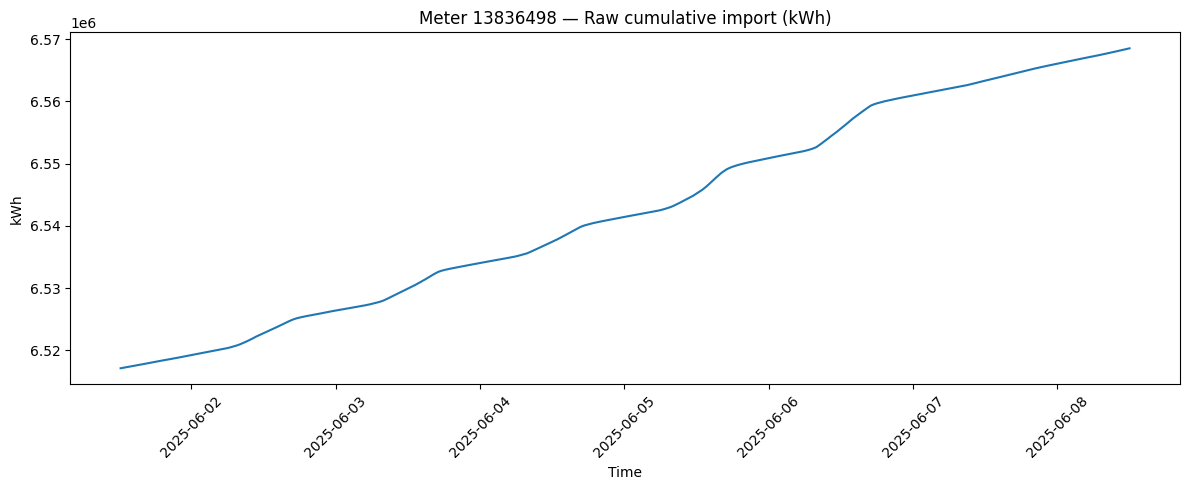

[PLOT] Saved: plots\consumption_15min_vs_clean_13836498.png


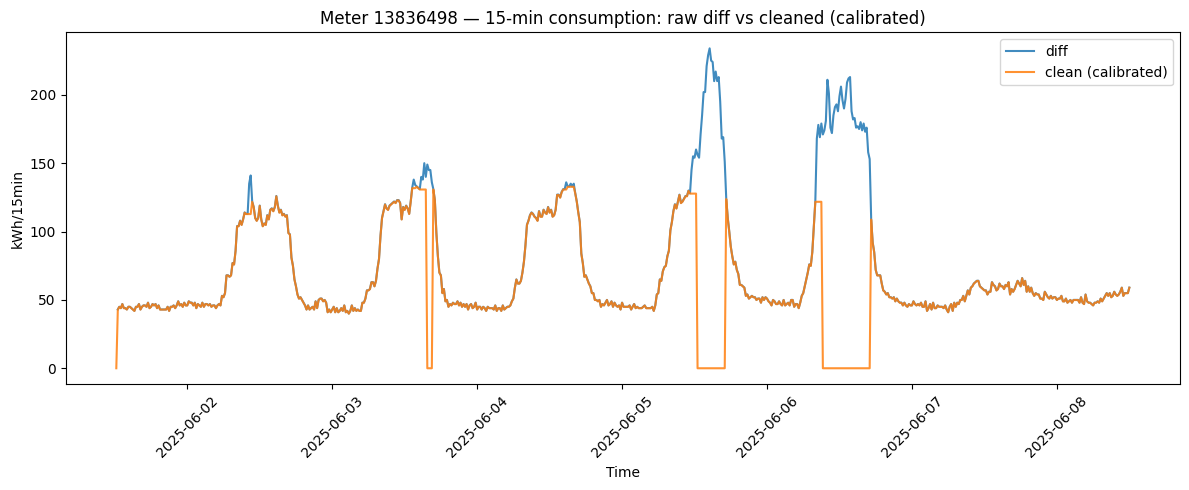

[PLOT] Saved: plots\raw_cumulative_import_14098248.png


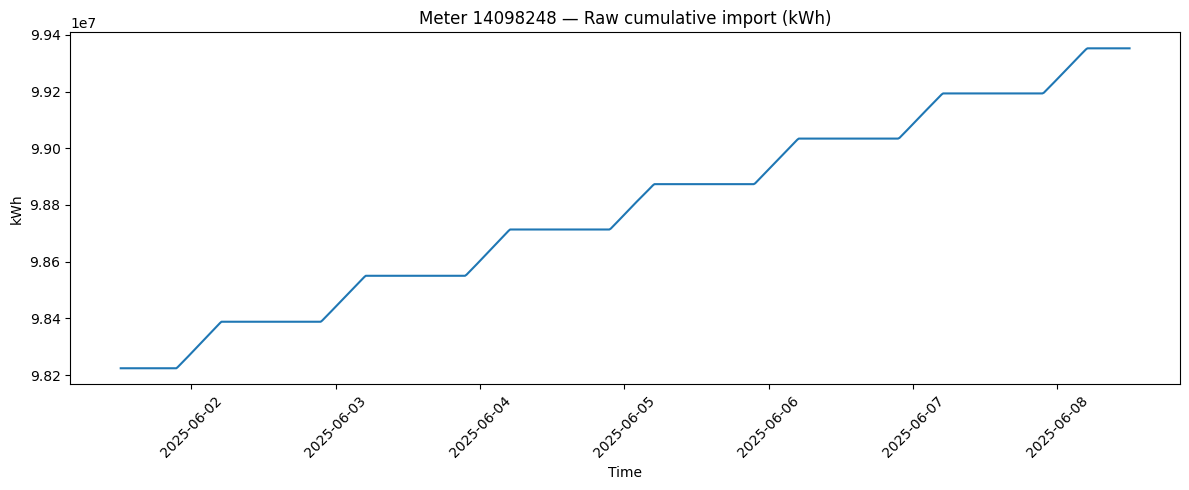

[PLOT] Saved: plots\consumption_15min_vs_clean_14098248.png


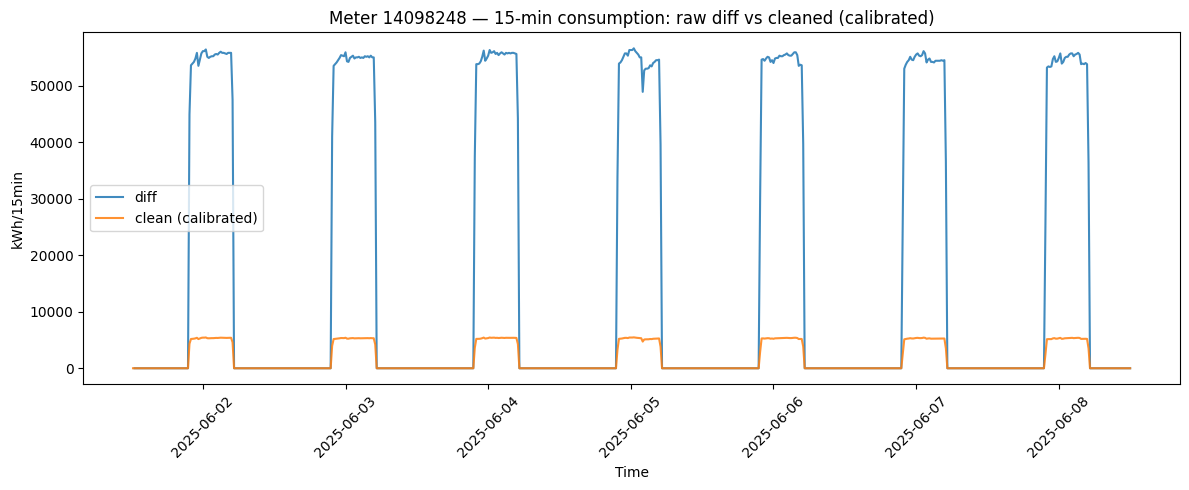

[PLOT] Saved: plots\raw_cumulative_import_14101503.png


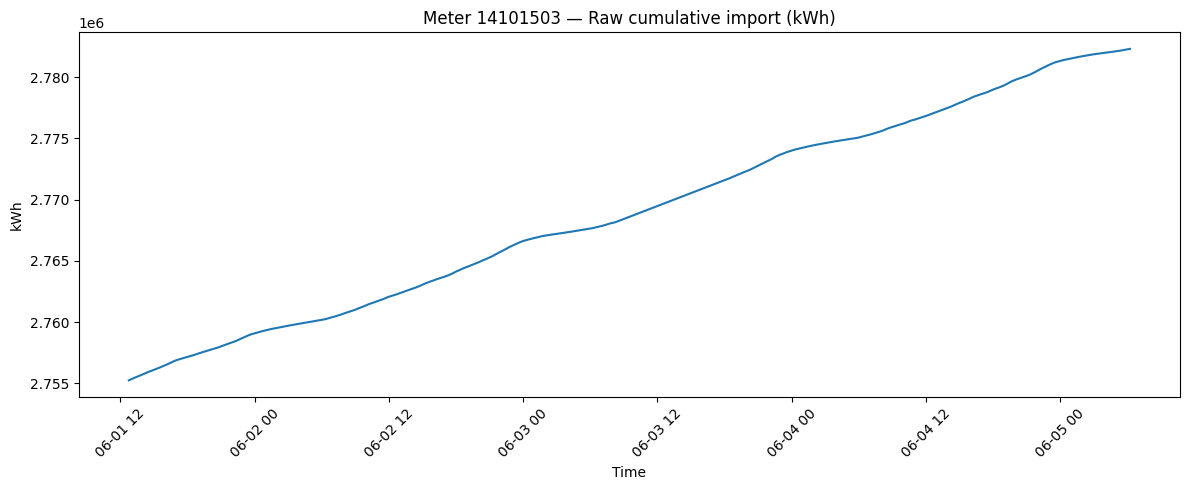

[PLOT] Saved: plots\consumption_15min_vs_clean_14101503.png


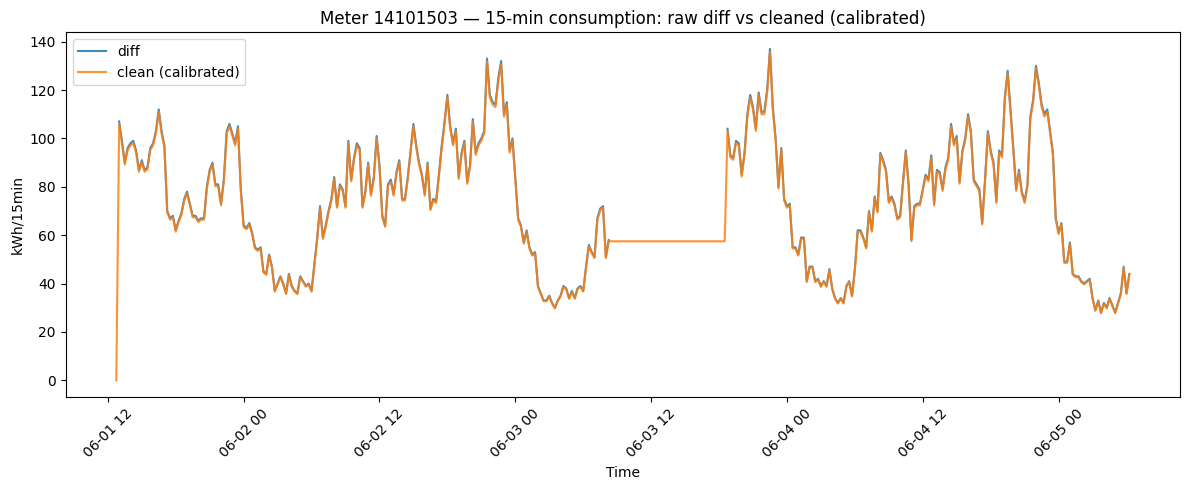

In [17]:
raw = load_all(str(DATA_DIR))
clean = compute_clean(raw, k_mad=6.0)
clean_cal, calib_table, daily_flags = calibrate_and_flag_completeness(clean)
hourly = aggregate(clean_cal, "h")

validation_reports(clean_cal, hourly, daily_flags)

### Iterative process

We didn’t get it right on the first try—and that was useful. Early on, several CSVs failed (`“No columns to parse”`), concatenation crashed (`“No objects to concatenate”`), and a KeyError: `'meter_id'` exposed inconsistent headers and types. In notebooks `__file__` wasn’t defined, so paths broke; in PyCharm plots didn’t appear and later our `save_or_show()` signature mismatch + reused filenames meant either no images or overwritten ones. On the data side, raw diffs had rollover spikes; our first completeness rule was too lenient (days for meter 13836498 with ~0.6/0.39 ratios slipped through), and meter 14098248 stayed ~10× because calibration never merged (dtype mismatch) and plausibility filtering excluded all its days. We fixed ingestion (separator/encoding + header heuristics), normalized `meter_id` to string, added three-step cleaning (MAD clip, ≤1h ffill, learned physical cap), tightened completeness (≥95% intervals + ≥23 hours/span), implemented multi-stage calibration (plausible → complete → total-series), added a system-level cap, wrote validation reports (clip %, energy conservation, suspect days), and made plotting robust with a plots/ folder and unique filenames. The result is a clean, calibrated, auditable dataset that survived all those dead ends.